# Fifa Screenshot Classifier
---

Model input is a resized screenshot to 224x224

---
## Setup

In [1]:
%matplotlib inline

### Imports

In [2]:
# Built-ins
import os
from pathlib import Path
from datetime import datetime
date_string = "{:%Y.%m.%d}".format(datetime.now())

In [3]:
# Tensorflow
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD
print(f"Tensorflow Version: {tf.__version__}")

# Reset notebook state
tf.keras.backend.clear_session()


Tensorflow Version: 2.0.0


In [4]:
# Pip installs
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from loguru import logger

# Import local config
from fifa_screenshot_classifier import config
from fifa_screenshot_classifier.model import FifaClassifierNet

2019-12-18 02:20:05.818 | DEBUG    | fifa_screenshot_classifier.config:<module>:26 - Date string is set to: {date_string}
2019-12-18 02:20:05.821 | DEBUG    | fifa_screenshot_classifier.config:<module>:69 - Model Path set to: {MODEL_PATH}


In [5]:
vgg16_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_tensor=tf.keras.Input(shape=(224,224,3)))

In [6]:
TRAINING = True
VERBOSE = True
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [7]:
if VERBOSE:
    config.print_config_report()

2019-12-18 02:20:07.076 | INFO     | fifa_screenshot_classifier.config:print_config_report:97 - Input image Dimensions: 224x224
2019-12-18 02:20:07.078 | INFO     | fifa_screenshot_classifier.config:print_config_report:98 - DATA_DIR: data/game_not_game
2019-12-18 02:20:07.089 | INFO     | fifa_screenshot_classifier.config:print_config_report:99 - Model will be saved to models/fifa_screenshot_classifier.h5
2019-12-18 02:20:07.090 | INFO     | fifa_screenshot_classifier.config:print_config_report:100 - 2 classes found
2019-12-18 02:20:07.092 | INFO     | fifa_screenshot_classifier.config:print_config_report:101 - CLASS_NAMES: ['game' 'not_game']
2019-12-18 02:20:07.093 | INFO     | fifa_screenshot_classifier.config:print_config_report:102 - 401 train images
2019-12-18 02:20:07.177 | INFO     | fifa_screenshot_classifier.config:print_config_report:103 - 51 test images
2019-12-18 02:20:07.180 | INFO     | fifa_screenshot_classifier.config:print_config_report:104 - Learning Rate: 0.01
2019-

---
## Helper Functions

In [8]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(config.CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

In [9]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  
  # The second to last is the class-directory
  return parts[-2] == config.CLASS_NAMES

In [10]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)

  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)

  # resize the image to the desired size.
  return tf.image.resize(img, [config.IMG_WIDTH, config.IMG_HEIGHT])

In [11]:
def process_path(file_path):
  label = get_label(file_path)

  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  
  return img, label

In [12]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(config.BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [13]:
def load_model(model_path):
    return

## Load using `tf.data`

The above `keras.preprocessing` method is convienient, but has two downsides: 

1. It's slow. See the performance section below.
1. It lacks fine-grained control.
1. It is not well integrated with the rest of TensorFlow.

To load the files as a `tf.data.Dataset` first create a dataset of the file paths:

In [14]:
list_train_ds = tf.data.Dataset.list_files(str(config.TRAIN_DIR/'*/*.jpg'))
list_test_ds = tf.data.Dataset.list_files(str(config.TEST_DIR/'*/*.jpg'))

In [15]:
if VERBOSE:
  # Inspect the train and test dataset list
  print("-"*30, " Training", "-"*30)
  for f in list_train_ds.take(5):
    print(f.numpy())

  print("-"*30, " Test Set", "-"*30)
  for f in list_test_ds.take(5):
    print(f.numpy())

------------------------------  Training ------------------------------
b'data/game_not_game/train/game/smwk_00043.jpg'
b'data/game_not_game/train/game/qoix_00037.jpg'
b'data/game_not_game/train/not_game/00004.jpg'
b'data/game_not_game/train/game/reyv_00006.jpg'
b'data/game_not_game/train/game/smwk_00023.jpg'
------------------------------  Test Set ------------------------------
b'data/game_not_game/test/game/wmpi_00024.jpg'
b'data/game_not_game/test/game/wmpi_00023.jpg'
b'data/game_not_game/test/not_game/glad_00166.jpg'
b'data/game_not_game/test/not_game/glad_00119.jpg'
b'data/game_not_game/test/not_game/glad_00107.jpg'


Use `Dataset.map` to create a dataset of `image, label` pairs:

In [16]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_train_ds = list_train_ds.map(process_path, num_parallel_calls=AUTOTUNE)

labeled_test_ds = list_test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [17]:
if VERBOSE:
  for image, label in labeled_train_ds.take(5):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [False  True]
Image shape:  (224, 224, 3)
Label:  [ True False]
Image shape:  (224, 224, 3)
Label:  [False  True]
Image shape:  (224, 224, 3)
Label:  [False  True]
Image shape:  (224, 224, 3)
Label:  [ True False]


### Basic methods for training

To train a model with this dataset you will want the data:

* To be well shuffled.
* To be batched.
* Batches to be available as soon as possible.

These features can be easily added using the `tf.data` api.

In [18]:
train_ds = prepare_for_training(labeled_train_ds)
test_ds = prepare_for_training(labeled_test_ds)

image_batch, label_batch = next(iter(train_ds))

---
# Build the dataset a different way

In [19]:
# train_path = '/data/game_not_game/train'
# valid_path = '/data/game_not_game/valid'
# test_path = '/data/game_not_game/test'
# train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), classes=['game', 'not_game'], batch_size=32)
# valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224), classes=['game', 'not_game'], batch_size=32)
# test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), classes=['game', 'not_game'], batch_size=32)

---
## VGG16 Model

In [20]:
# for layer in vgg16_model.layers[:-4]:
#     layer.trainable = False# for layer in vgg16_model.layers[:-4]:
#     layer.trainable = False

# # Create the model
# model = tf.keras.Sequential()
 
# # Add the vgg convolutional base model
# model.add(vgg16_model)
 
# # Add new layers
# model.add(Flatten())
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(2, activation='softmax'))
 
# # Show a summary of the model. Check the number of trainable parameters
# model.summary()

---
## Inspect the Datset

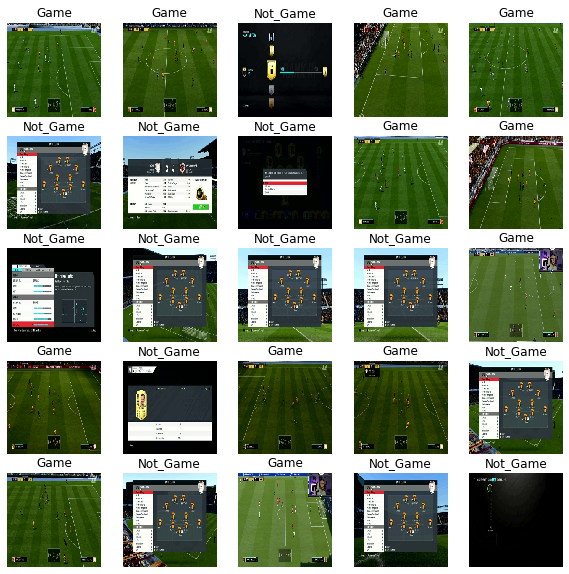

In [21]:
if VERBOSE:
    show_batch(image_batch.numpy(), label_batch.numpy())

---
## The Model

### Optimizer

In [22]:
# define the optimizer
opt = SGD(lr=config.INIT_LR, 
	momentum=0.9,
	decay=config.INIT_LR / config.EPOCHS)

### Build the Model

In [23]:
# Build the model
print("[INFO] building the model...")
model = FifaClassifierNet.build(width=config.IMG_WIDTH, height=config.IMG_HEIGHT, depth=3,
	classes=len(config.CLASS_NAMES))

[INFO] building the model...


### Compile the Model

In [24]:
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

---
## Train/Load the Model

In [25]:
checkpoint_path = "checkpints"

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=0, 
    save_weights_only=True,
    save_freq=5)

In [26]:
def graph_results():
    global H
    # construct a plot that plots and saves the training history
    N = np.arange(0, config.EPOCHS)
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(N, H.history["loss"], label="train_loss")
    plt.plot(N, H.history["val_loss"], label="val_loss")
    plt.plot(N, H.history["accuracy"], label="train_acc")
    plt.plot(N, H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig(config.TRAINING_PLOT_PATH)

In [27]:
if TRAINING:
    print("[INFO] Training Model...")
    # Train the model
    H = model.fit_generator(
        train_ds,
        steps_per_epoch=config.TOTAL_NUM_TRAIN_IMAGES // config.BATCH_SIZE,
        epochs=config.EPOCHS,
        validation_data=test_ds,
        validation_steps=config.TOTAL_NUM_TEST_IMAGES // config.BATCH_SIZE,
        # callbacks=[cp_callback],
        verbose=VERBOSE,
    )

[INFO] Training Model...
Epoch 1/100
12/12 [==============================] - 66s 5s/step - loss: 0.2235 - accuracy: 0.9089 - val_loss: 0.6605 - val_accuracy: 0.6250
Epoch 2/100
12/12 [==============================] - 67s 6s/step - loss: 0.0817 - accuracy: 0.9818 - val_loss: 0.6404 - val_accuracy: 0.6562
Epoch 3/100
12/12 [==============================] - 68s 6s/step - loss: 0.0350 - accuracy: 0.9870 - val_loss: 0.6627 - val_accuracy: 0.6250
Epoch 4/100
12/12 [==============================] - 72s 6s/step - loss: 0.0426 - accuracy: 0.9844 - val_loss: 0.6757 - val_accuracy: 0.6250
Epoch 5/100
12/12 [==============================] - 86s 7s/step - loss: 0.0332 - accuracy: 0.9948 - val_loss: 0.7607 - val_accuracy: 0.5625
Epoch 6/100
12/12 [==============================] - 85s 7s/step - loss: 0.0832 - accuracy: 0.9792 - val_loss: 0.8871 - val_accuracy: 0.6875
Epoch 7/100
12/12 [==============================] - 92s 8s/step - loss: 0.0649 - accuracy: 0.9818 - val_loss: 1.5876 - val_accur

[INFO] Model finished fitting!


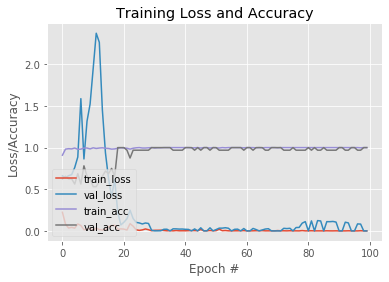

In [28]:
if TRAINING:
    print("[INFO] Model finished fitting!")
    graph_results()

---
## Save the Model

In [29]:
print(f"[INFO] saving serialized network to {config.MODEL_PATH}")
model.save(str(config.MODEL_PATH))

[INFO] saving serialized network to models/fifa_screenshot_classifier.h5


---
## Load the Model (if not training)

In [ ]:
if not TRAINING:
    print("[INFO] loading pre-trained model...")
    model = tf.keras.models.load_model("models/fifa_screenshot_classifier.h5")
    if VERBOSE: print(model.summary()) 

---
## Evaluate the network

In [30]:
# evaluate the network and show a classification report
print("[INFO] evaluating network...")
predictions = model.predict(test_ds, steps=config.TOTAL_NUM_TRAIN_IMAGES // config.BATCH_SIZE)

[INFO] evaluating network...


---
# Test the Model

In [31]:
# test_path = Path("data/fifa_screenshot_classifier/unsorted")
test_path = Path("data/fifa_screenshot_classifier/test")
assert test_path.is_dir()

In [32]:
test_batches = tf.keras.preprocessing.image.ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), batch_size=32)


Found 114 images belonging to 12 classes.


In [33]:
test_imgs, test_labels = next(test_batches)
predictions = model.predict(test_imgs)

In [34]:
for p in predictions:
    print(p)

[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]


In [ ]:
# define the path to the output directory that will store our final
# output with labels/annotations along with the number of images to
# sample
OUTPUT_IMAGE_PATH = os.path.sep.join(["output", "examples"])
SAMPLE_SIZE = 50

---
# Footnotes